In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q timm wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 98.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.1/309.1 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.7 MB/s eta 0:00:00


In [3]:
import os
import gc
import sys
import zipfile
from PIL import Image
import cv2
import math, random
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

from collections import OrderedDict

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW

import timm
from transformers import get_cosine_schedule_with_warmup

import albumentations as A

from sklearn.model_selection import KFold

# import wandb
# wandb.login()

In [4]:
from_dir = '/content/drive/MyDrive/Kaggle/rsna-2024-lsdc-train/'
file_name = 'cvt_png.zip'
to_dir = '/content/rsna-2024-lsdc-train/'

!mkdir -p {to_dir}

!rsync -ah --progress {from_dir + file_name} {to_dir}

zip_path = os.path.join(to_dir, file_name)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    total_files = len(zip_ref.infolist())
    with tqdm(total=total_files, desc="Unzipping", unit="files") as pbar:
        for file in zip_ref.infolist():
            zip_ref.extract(file, to_dir)
            pbar.update(1)

!du -sh {to_dir}

sending incremental file list
cvt_png.zip
         10.58G 100%   64.58MB/s    0:02:36 (xfr#1, to-chk=0/1)


Unzipping: 100%|██████████| 86769/86769 [01:14<00:00, 1164.40files/s]


20G	/content/rsna-2024-lsdc-train/


In [5]:
# ORIGINAL DATASET PATH
# INPUT_PATH  = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification'
INPUT_PATH  = '/content/drive/MyDrive/Kaggle/rsna-2024-lumbar-spine-degenerative-classification'

# PNG FILE PATH
# PNG_PATH = '/kaggle/input/rsna24lsdc-0815-eda-dcm2png' # Add Input -> Your Work + Notebook -> rsna24lsdc_0815_eda_dcm2png
PNG_PATH = '/content/rsna-2024-lsdc-train'

# MODEL OUTPUT PATH
# OUTPUT_PATH = '/kaggle/working'
OUTPUT_PATH = '/content/drive/MyDrive/Kaggle/rsna-2024-lsdc-train'

In [6]:
IMG_SIZE = (512, 512)
# IMG_SIZE = (224, 224)

IN_CHANS = 40
N_LABELS = 25
N_CLASSES = 3 * N_LABELS

AUG_PROB = 0.75

EPOCHS = 20
EARLY_STOPPING_EPOCH = 3

N_FOLDS = 5

MODEL_NAME = "edgenext_base.in21k_ft_in1k"          # 18M,  72MB
# MODEL_NAME = "tf_efficientnetv2_s"                  # 22M,  87MB
# MODEL_NAME = "convnext_tiny.fb_in22k_ft_in1k"       # 28M,  111MB
# MODEL_NAME = "convnextv2_tiny.fcmae_ft_in22k_in1k"  # 29M,  114MB
# MODEL_NAME = "convnextv2_small.fcmae_ft_in22k_in1k" # 50M,  200MB
# MODEL_NAME = "convnextv2_base.fcmae_ft_in22k_in1k"  # 89M,  356MB
# MODEL_NAME = "convnextv2_large.fcmae_ft_in22k_in1k" # 198M, 792MB
# MODEL_NAME = "swin_tiny_patch4_window7_224"         # 28M,  110MB
# MODEL_NAME = "swin_small_patch4_window7_224"        # 50M,  196MB
# MODEL_NAME = "swin_base_patch4_window7_224"         # 88M,  345MB
# MODEL_NAME = "swin_large_patch4_window7_224"        # 197M, 772MB

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

N_WORKERS = os.cpu_count()
print(N_WORKERS)

USE_AMP = True # Automatic Mixed Precision - True if using T4 or newer

BATCH_SIZE = 32
# BATCH_SIZE = 128

LR = 2e-4
MIN_LR = 1e-6
WD = 1e-2

SEED = 8620
def set_random_seed(seed: int = 8620, deterministic: bool = False):
    """Set seeds"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = deterministic  # type: ignore
set_random_seed(SEED)

12


In [7]:
df = pd.read_csv(f'{INPUT_PATH}/train.csv')
df.head()

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild


In [8]:
df = df.fillna(-100)
label2id = {'Normal/Mild': 0, 'Moderate':1, 'Severe':2}
df = df.replace(label2id)
df.head()

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,4646740,0,0,1,2,0,0,0,0,1,...,0,0,0,2,0,0,1,1,1,0
2,7143189,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8785691,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,10728036,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [9]:
# 예외처리 할 study_id들 제거

print(len(df))

study_ids_to_remove = [3008676218, 2780132468, 2492114990]
df = df[~df['study_id'].isin(study_ids_to_remove)]

print(len(df))

1975
1972


In [10]:
class RSNA24Dataset(Dataset):
    def __init__(self, df, phase='train', transform=None):
        self.df = df
        self.transform = transform
        self.phase = phase

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x = np.zeros((512, 512, IN_CHANS), dtype=np.uint8)
        t = self.df.iloc[idx]
        st_id = int(t['study_id'])
        label = t[1:].values.astype(np.int64)

        # Sagittal T1
        for i in range(10):
            try:
                img_path = f'{PNG_PATH}/cvt_png/{st_id}/Sagittal T1/{i+1:02d}.png'
                img = Image.open(img_path).convert('L') # single channel gray scale - luminance
                img = np.array(img)
                x[..., i] = img.astype(np.uint8)
            except:
                print(f'failed to load on {st_id}, Sagittal T1')

        # Sagittal T2/STIR
        for i in range(10):
            try:
                img_path = f'{PNG_PATH}/cvt_png/{st_id}/Sagittal T2_STIR/{i+1:02d}.png'
                img = Image.open(img_path).convert('L')
                img = np.array(img)
                x[..., i+10] = img.astype(np.uint8)
            except:
                print(f'failed to load on {st_id}, Sagittal T2/STIR')

        # Axial T2
        for i in range(20):
            try:
                img_path = f'{PNG_PATH}/cvt_png/{st_id}/Axial T2/{i+1:02d}.png'
                img = Image.open(img_path).convert('L')
                img = np.array(img)
                x[..., i+20] = img.astype(np.uint8)
            except:
                print(f'failed to load on {st_id}, Axial T2')

        if self.transform is not None:
            x = self.transform(image=x)['image']
        x = x.transpose(2, 0, 1)

        return x, label

In [11]:
transforms_train = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=AUG_PROB),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=AUG_PROB),
    A.OneOf([
        A.MotionBlur(blur_limit=3),
        A.MedianBlur(blur_limit=3),
        A.GaussianBlur(blur_limit=3),
        A.GaussNoise(var_limit=(3.0, 9.0)),
    ], p=AUG_PROB),
    A.OneOf([
        A.OpticalDistortion(distort_limit=1.0),
        A.GridDistortion(num_steps=5, distort_limit=1.0),
        A.ElasticTransform(alpha=3),
    ], p=AUG_PROB),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=AUG_PROB),
    A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
    A.CoarseDropout(max_holes=16, max_height=int(IMG_SIZE[0] * 0.125), max_width=int(IMG_SIZE[1] * 0.125),
                    min_holes=1, min_height=int(IMG_SIZE[0] * 0.03125), min_width=int(IMG_SIZE[1] * 0.03125),
                    p=AUG_PROB),
    A.Normalize(mean=0.5, std=0.5)
])

transforms_val = A.Compose([
    A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
    A.Normalize(mean=0.5, std=0.5)
])

/usr/local/lib/python3.10/dist-packages/pydantic/main.py:193: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  self.__pydantic_validator__.validate_python(data, self_instance=self)


Sample 1:
Input tensor shape: torch.Size([1, 40, 512, 512])
Input tensor stats - Min: -1.00, Max: 0.97, Mean: -0.58, Std: 0.37
Target: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
         0]]), Shape: torch.Size([1, 25])


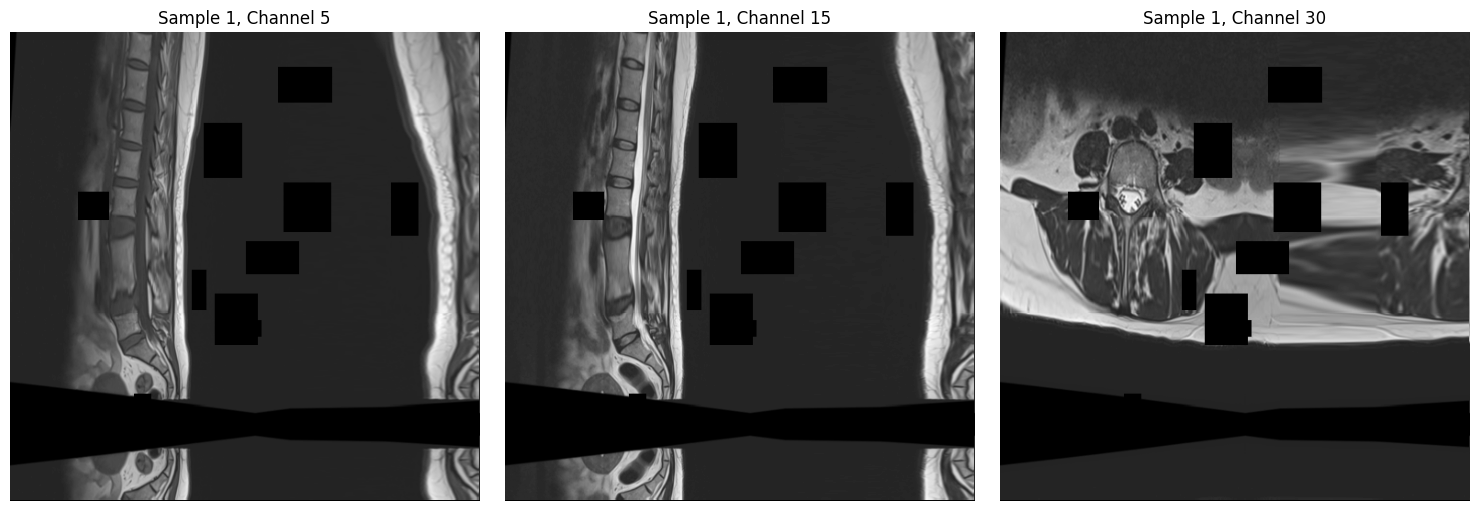

Channel 5 stats - Min: -1.00, Max: 0.89, Mean: -0.61, Std: 0.36
Channel 15 stats - Min: -1.00, Max: 0.84, Mean: -0.60, Std: 0.37
Channel 30 stats - Min: -1.00, Max: 0.87, Mean: -0.54, Std: 0.40

Sample 2:
Input tensor shape: torch.Size([1, 40, 512, 512])
Input tensor stats - Min: -1.00, Max: 1.00, Mean: -0.72, Std: 0.32
Target: tensor([[0, 0, 1, 2, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 1, 1, 1,
         0]]), Shape: torch.Size([1, 25])


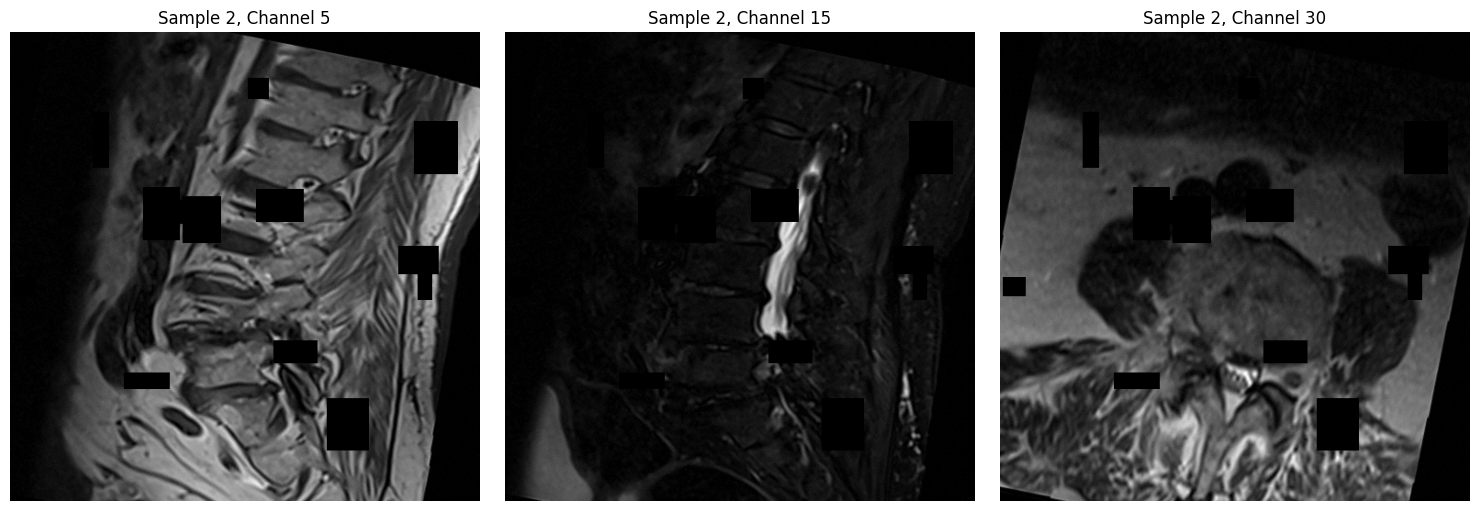

Channel 5 stats - Min: -1.00, Max: 1.00, Mean: -0.59, Std: 0.37
Channel 15 stats - Min: -1.00, Max: 0.98, Mean: -0.89, Std: 0.17
Channel 30 stats - Min: -1.00, Max: 0.97, Mean: -0.66, Std: 0.32



In [12]:
tmp_ds = RSNA24Dataset(df, phase='train', transform=transforms_train)
tmp_dl = DataLoader(
    tmp_ds,
    batch_size=1,
    shuffle=False,
    pin_memory=True,
    drop_last=False,
    num_workers=0
)

def display_channel(input_tensor, channel, title):
    channel_image = input_tensor[0, channel].numpy()
    channel_image = (channel_image - channel_image.min()) / (channel_image.max() - channel_image.min())
    plt.imshow(channel_image, cmap='gray')
    plt.title(title)
    plt.axis('off')

for i, (input_tensor, target) in enumerate(tmp_dl):
    if i == 2:
        break

    print(f"Sample {i+1}:")
    print(f"Input tensor shape: {input_tensor.shape}")
    print(f"Input tensor stats - Min: {input_tensor.min():.2f}, Max: {input_tensor.max():.2f}, Mean: {input_tensor.mean():.2f}, Std: {input_tensor.std():.2f}")
    print(f"Target: {target}, Shape: {target.shape}")

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    display_channel(input_tensor, 5, f"Sample {i+1}, Channel 5")

    plt.subplot(1, 3, 2)
    display_channel(input_tensor, 15, f"Sample {i+1}, Channel 15")

    plt.subplot(1, 3, 3)
    display_channel(input_tensor, 30, f"Sample {i+1}, Channel 30")

    plt.tight_layout()
    plt.show()

    print(f"Channel 5 stats - Min: {input_tensor[0, 5].min():.2f}, Max: {input_tensor[0, 5].max():.2f}, Mean: {input_tensor[0, 5].mean():.2f}, Std: {input_tensor[0, 5].std():.2f}")
    print(f"Channel 15 stats - Min: {input_tensor[0, 15].min():.2f}, Max: {input_tensor[0, 15].max():.2f}, Mean: {input_tensor[0, 15].mean():.2f}, Std: {input_tensor[0, 15].std():.2f}")
    print(f"Channel 30 stats - Min: {input_tensor[0, 30].min():.2f}, Max: {input_tensor[0, 30].max():.2f}, Mean: {input_tensor[0, 30].mean():.2f}, Std: {input_tensor[0, 30].std():.2f}")
    print()

plt.close()
del tmp_ds, tmp_dl

In [13]:
# class RSNA24Model(nn.Module):
#     def __init__(self, model_name, in_chans=40, num_classes=75, pretrained=True, features_only=False):
#         super().__init__()
#         self.model = timm.create_model(
#                                     model_name,
#                                     pretrained=pretrained,
#                                     features_only=features_only,
#                                     in_chans=in_chans,
#                                     num_classes=num_classes,
#                                     global_pool='avg'
#                                     )

#     def forward(self, x):
#         y = self.model(x)
#         return y

In [14]:
class ClassificationModule(nn.Module):
#     def __init__(self, in_channels, num_classes, hidden_dim=512):
#         super().__init__()
#         self.conv = nn.Conv2d(in_channels, hidden_dim, kernel_size=3, padding=1)
#         self.bn = nn.BatchNorm2d(hidden_dim)
#         self.pool = nn.AdaptiveAvgPool2d(1)
#         self.fc = nn.Linear(hidden_dim, num_classes)

#     def forward(self, x):
#         x = torch.relu(self.bn(self.conv(x)))
#         x = self.pool(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)
#         return x

    def __init__(self, in_channels, num_classes, hidden_dim=512):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden_dim, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(hidden_dim)
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(hidden_dim)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class RSNA24Model(nn.Module):
    def __init__(self, base_model_name, in_chans, num_classes, pretrained=True):
        super().__init__()
        self.base_model = timm.create_model(base_model_name, pretrained=pretrained, in_chans=in_chans, features_only=True)

        # Freeze/Update the base model
        for param in self.base_model.parameters():
            param.requires_grad = True

        # Get the number of output features from the last layer of the base model
        with torch.no_grad():
            dummy_input = torch.randn(1, in_chans, IMG_SIZE[0], IMG_SIZE[1])
            features = self.base_model(dummy_input)
            in_features = features[-1].shape[1]  # Use the last feature map

            # i.e., if features[-1].shape is (1, 512, 7, 7),
            # then features[-1].shape[1] would be 512.
            # we're feeding it into a conv layer, so we need in_channels only.

        # Add custom classification module
        self.classification_module = ClassificationModule(in_features, num_classes)

    def forward(self, x):
        features = self.base_model(x)
        output = self.classification_module(features[-1])  # Use the last feature map
        return output.view(output.size(0), -1)  # Reshape to (batch_size, num_classes * 3)

In [15]:
m = RSNA24Model(MODEL_NAME, in_chans=IN_CHANS, num_classes=N_CLASSES, pretrained=False)
i = torch.randn(2, IN_CHANS, IMG_SIZE[0], IMG_SIZE[1])
out = m(i)
for o in out:
    print(o.shape, o.min(), o.max())

del m, i, out

torch.Size([75]) tensor(-0.4611, grad_fn=<MinBackward1>) tensor(0.6823, grad_fn=<MaxBackward1>)
torch.Size([75]) tensor(-0.4432, grad_fn=<MinBackward1>) tensor(0.6565, grad_fn=<MaxBackward1>)


In [16]:
# Setup automatic mixed precision (AMP) for faster training and reduced memory usage
# autocast = torch.cuda.amp.autocast(enabled=USE_AMP, dtype=torch.bfloat16) # for newer Ampere GPUs
autocast = torch.cuda.amp.autocast(enabled=USE_AMP, dtype=torch.half) # for T4 or newer GPUs

# Initialize gradient scaler for AMP
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP, init_scale=4096)

# wandb.init(project="rsna24lsdc", config={
#     "learning_rate": LR,
#     "epochs": EPOCHS,
#     "batch_size": BATCH_SIZE,
#     "architecture": MODEL_NAME,
#     "weight_decay": WD
# })

# Setup K-Fold cross-validation
skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

<ipython-input-16-4de697ab3fc5>:3: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  autocast = torch.cuda.amp.autocast(enabled=USE_AMP, dtype=torch.half) # for T4 or newer GPUs
<ipython-input-16-4de697ab3fc5>:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP, init_scale=4096)


In [ ]:
for fold, (trn_idx, val_idx) in enumerate(skf.split(range(len(df)))):
    print('#'*30)
    print(f'start fold {fold}')
    print('#'*30)
    print(len(trn_idx), len(val_idx))
    df_train = df.iloc[trn_idx]
    df_valid = df.iloc[val_idx]

    # Create training dataset and dataloader
    train_ds = RSNA24Dataset(df_train, phase='train', transform=transforms_train)
    train_dl = DataLoader(
                train_ds,
                batch_size=BATCH_SIZE,
                shuffle=True,
                pin_memory=True,
                drop_last=True,
                num_workers=N_WORKERS
                )

    # Create validation dataset and dataloader
    valid_ds = RSNA24Dataset(df_valid, phase='valid', transform=transforms_val)
    valid_dl = DataLoader(
                valid_ds,
                batch_size=BATCH_SIZE,
                shuffle=False,
                pin_memory=True,
                drop_last=False,
                num_workers=N_WORKERS
                )

    # Initialize the model
    model = RSNA24Model(MODEL_NAME, IN_CHANS, N_CLASSES, pretrained=True)
    model.to(device)

    # Setup optimizer
    optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WD)

    class CosineScheduleWithMinLR:
        def __init__(self, scheduler, min_lr):
            self.scheduler = scheduler
            self.min_lr = min_lr

        def step(self):
            # Perform the cosine scheduler step
            self.scheduler.step()
            # Enforce the minimum learning rate
            for param_group in self.scheduler.optimizer.param_groups:
                param_group['lr'] = max(param_group['lr'], self.min_lr)

        def get_last_lr(self):
            # Return the last learning rate applied
            return [max(lr, self.min_lr) for lr in self.scheduler.get_last_lr()]

    # Setup learning rate scheduler with warmup
    warmup_steps = EPOCHS / 10 * len(train_dl)
    num_total_steps = EPOCHS * len(train_dl)
    num_cycles = 0.475

    # Get the default cosine schedule
    cosine_scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=num_total_steps,
        num_cycles=num_cycles
    )

    # Wrap the cosine scheduler with the custom scheduler
    scheduler = CosineScheduleWithMinLR(cosine_scheduler, MIN_LR)

    # Setup weighted loss function
    weights = torch.tensor([1.0, 2.0, 4.0])
    criterion = nn.CrossEntropyLoss(weight=weights.to(device))
    criterion2 = nn.CrossEntropyLoss(weight=weights)

    best_loss = math.log(N_CLASSES)
    best_wll = math.log(N_CLASSES)
    es_step = 0

    # Training loop
    for epoch in range(1, EPOCHS + 1):
        print(f'start epoch {epoch}')
        model.train()
        total_loss = 0
        for idx, (x, t) in enumerate(tqdm(train_dl)):
            x = x.to(device)
            t = t.to(device)

            optimizer.zero_grad()

            with autocast:
                loss = 0
                y = model(x)
                # Calculate loss for each label
                for col in range(N_LABELS):
                    pred = y[:, col*3:col*3+3]
                    gt = t[:, col]
                    loss = loss + criterion(pred, gt) / N_LABELS

                total_loss += loss.item()

            # Check for NaN loss
            if not math.isfinite(loss):
                print(f"Loss is {loss}, stopping training")
                sys.exit(1)

            # Backward pass with gradient scaling
            scaler.scale(loss).backward()

            scaler.step(optimizer)
            scaler.update()

            if scheduler is not None:
                scheduler.step()

        train_loss = total_loss / len(train_dl)
        print(f'train_loss: {train_loss:.6f}')

        # Log training metrics to W&B
        # wandb.log({
        #     "Epoch": epoch,
        #     "Train Loss": train_loss,
        #     "Learning Rate": optimizer.param_groups[0]["lr"]
        # })

        # Validation loop
        total_loss = 0
        y_preds = []
        labels = []

        model.eval()
        with torch.no_grad():
            for idx, (x, t) in enumerate(tqdm(valid_dl)):
                x = x.to(device)
                t = t.to(device)

                with autocast:
                    loss = 0
                    y = model(x)
                    for col in range(N_LABELS):
                        pred = y[:, col*3:col*3+3]
                        gt = t[:, col]

                        loss = loss + criterion(pred, gt) / N_LABELS
                        y_pred = pred.float()
                        y_preds.append(y_pred.cpu())
                        labels.append(gt.cpu())

                    total_loss += loss.item()

        val_loss = total_loss / len(valid_dl)

        # Calculate validation metrics
        y_preds = torch.cat(y_preds, dim=0)
        labels = torch.cat(labels)
        val_wll = criterion2(y_preds, labels)

        print(f'val_loss: {val_loss:.6f}, val_wll: {val_wll:.6f}')

        # Log validation metrics to W&B
        # wandb.log({
        #     "Epoch": epoch,
        #     "Validation Loss": val_loss,
        #     "Validation WLL": val_wll
        # })

        # Save best model and update best scores
        if val_loss < best_loss or val_wll < best_wll:
            es_step = 0

            if device != 'cuda:0':
                model.to('cuda:0')

            if val_loss < best_loss:
                print(f'epoch: {epoch}, best loss updated from {best_loss:.6f} to {val_loss:.6f}')
                best_loss = val_loss

            output_dir = f'{OUTPUT_PATH}/rsna-2024-lsdc-trained-models'
            os.makedirs(output_dir, exist_ok=True)

            if val_wll < best_wll:
                print(f'epoch: {epoch}, best wll_metric updated from {best_wll:.6f} to {val_wll:.6f}')
                best_wll = val_wll
                fname = os.path.join(output_dir, f'best_wll_model_fold-{fold}.pt')
                torch.save(model.state_dict(), fname)

            if device != 'cuda:0':
                model.to(device)

        else:
            # Early stopping logic
            es_step += 1
            if es_step >= EARLY_STOPPING_EPOCH:
                print('early stopping')
                break

# After training all folds
# wandb.finish()
print("Training completed for all folds.")

##############################
start fold 0
##############################
1577 395


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/74.1M [00:00<?, ?B/s]

start epoch 1


100%|██████████| 49/49 [14:50<00:00, 18.18s/it]


train_loss: 1.025369


100%|██████████| 13/13 [04:45<00:00, 21.93s/it]


val_loss: 0.803738, val_wll: 0.838009
epoch: 1, best loss updated from 4.317488 to 0.803738
epoch: 1, best wll_metric updated from 4.317488 to 0.838009
start epoch 2


  0%|          | 0/49 [00:00<?, ?it/s]

In [ ]:
cv = 0
y_preds = []
labels = []
weights = torch.tensor([1.0, 2.0, 4.0])
criterion2 = nn.CrossEntropyLoss(weight=weights)

for fold, (trn_idx, val_idx) in enumerate(skf.split(range(len(df)))):
    print('#'*30)
    print(f'start fold{fold}')
    print('#'*30)
    df_valid = df.iloc[val_idx]
    valid_ds = RSNA24Dataset(df_valid, phase='valid', transform=transforms_val)
    valid_dl = DataLoader(
                valid_ds,
                batch_size=1,
                shuffle=False,
                pin_memory=True,
                drop_last=False,
                num_workers=N_WORKERS
                )

    model = RSNA24Model(MODEL_NAME, IN_CHANS, N_CLASSES, pretrained=False)
    fname = f'{OUTPUT_PATH}/rsna-2024-lsdc-trained-models/best_wll_model_fold-{fold}.pt'
    model.load_state_dict(torch.load(fname))
    model.to(device)

    model.eval()
    with tqdm(valid_dl, leave=True) as pbar:
        with torch.no_grad():
            for idx, (x, t) in enumerate(pbar):

                x = x.to(device)
                t = t.to(device)

                with autocast:
                    y = model(x)
                    for col in range(N_LABELS):
                        pred = y[:,col*3:col*3+3]
                        gt = t[:,col]
                        y_pred = pred.float()
                        y_preds.append(y_pred.cpu())
                        labels.append(gt.cpu())

y_preds = torch.cat(y_preds)
labels = torch.cat(labels)

cv = criterion2(y_preds, labels)
print('cv score:', cv.item())

In [ ]:
from sklearn.metrics import log_loss
y_pred_np = y_preds.softmax(1).numpy()
labels_np = labels.numpy()
y_pred_nan = np.zeros((y_preds.shape[0], 1))
y_pred2 = np.concatenate([y_pred_nan, y_pred_np],axis=1)
weights = []
for l in labels:
    if l==0: weights.append(1)
    elif l==1: weights.append(2)
    elif l==2: weights.append(4)
    else: weights.append(0)
cv2 = log_loss(labels, y_pred2, normalize=True, sample_weight=weights)
print('cv score:', cv2)

In [ ]:
np.save(f'{OUTPUT_PATH}/rsna-2024-lsdc-trained-models/labels.npy', labels_np)
np.save(f'{OUTPUT_PATH}/rsna-2024-lsdc-trained-models/final_oof.npy', y_pred2)